Note: It should be used ONLY ON TRAINING DATA.

In [122]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
negations = {'not', 'no', 'nor', 'never'}
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)



# nlp() ONLY trains TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

def nlp(df):
    df = df.dropna(subset=['body'])
    df['processed_review'] = df['body'].apply(clean_text)

    tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2))
    X = tfidf.fit_transform(df['processed_review'])

    return X, df, tfidf, clean_text




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priti.mujbaile\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priti.mujbaile\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\priti.mujbaile\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [124]:
df = pd.read_csv("Kaggle dataset.csv")

X, df, tfidf,  clean_text= nlp(df)  


C:\Users\priti.mujbaile\AppData\Local\Temp\ipykernel_23264\2418353808.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_review'] = df['body'].apply(clean_text)


## Model training

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [127]:
# Encode sentiment labels
le = LabelEncoder()
y = le.fit_transform(df['sentiments'])
# positive, negative, neutral → 0,1,2 (auto)

In [128]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [129]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000
)

model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [142]:
# Predictions
y_pred = model.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


# Detailed report
print("\nClassification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))


Accuracy: 82.24%

Classification Report:

              precision    recall  f1-score   support

    negative       0.63      0.28      0.39       307
     neutral       0.74      0.84      0.79      1260
    positive       0.90      0.90      0.90      1901

    accuracy                           0.82      3468
   macro avg       0.76      0.67      0.69      3468
weighted avg       0.82      0.82      0.81      3468



## Predict Sentiment for Amezon Reviews

In [149]:
# amazon_df = pd.read_csv("raw_reviews.csv")

amazon_df = pd.read_csv("raw_reviews.csv")
amazon_df = amazon_df.dropna(subset=['body'])

amazon_df['processed_review'] = amazon_df['body'].apply(clean_text)

A = tfidf.transform(amazon_df['processed_review'])

predict = model.predict(A)
amazon_df['predicted_sentiment'] = le.inverse_transform(predict)


In [150]:
# amazon_df = amazon_df.dropna(subset=['body'])
# #

In [151]:
# # A, amazon_df = nlp(amazon_df)

# amazon_df = pd.read_csv("raw_reviews.csv")
# amazon_df = amazon_df.dropna(subset=['body'])

# # reuse same clean_text logic
# amazon_df['processed_review'] = amazon_df['body'].apply(clean_text)

# # ONLY transform
# A = tfidf.transform(amazon_df['processed_review'])

# predict = model.predict(A)
# amazon_df['predicted_sentiment'] = le.inverse_transform(predict)



In [152]:
predict = model.predict(A)
amazon_df['predicted_sentiment'] = le.inverse_transform(predict)

predict



array([2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1,
       2, 2, 2, 1])

In [153]:
amazon_df[['body', 'predicted_sentiment']].head()


,body,predicted_sentiment
0,Good product very easy to use . Very high suct...,positive
1,Pros : Product has good quality and functional...,positive
2,the best in business. usually i dont write rev...,positive
3,i dont like this product,neutral
4,i dont like product,neutral


In [154]:
#check out that how many counts are there for positive and negative sentiments.
amazon_df['predicted_sentiment'].value_counts()


predicted_sentiment
positive    63
neutral      5
negative     2
Name: count, dtype: int64

## Wordcloud 

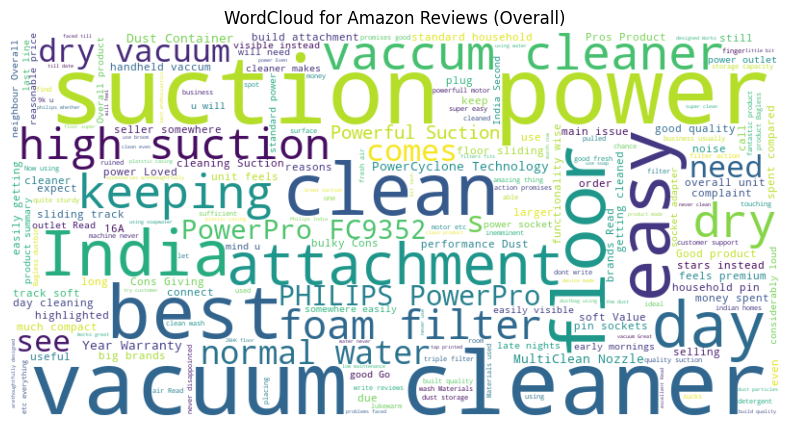

In [155]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(amazon_df['body'])

wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
)

wordcloud = wc.generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud for Amazon Reviews (Overall)")
plt.show()


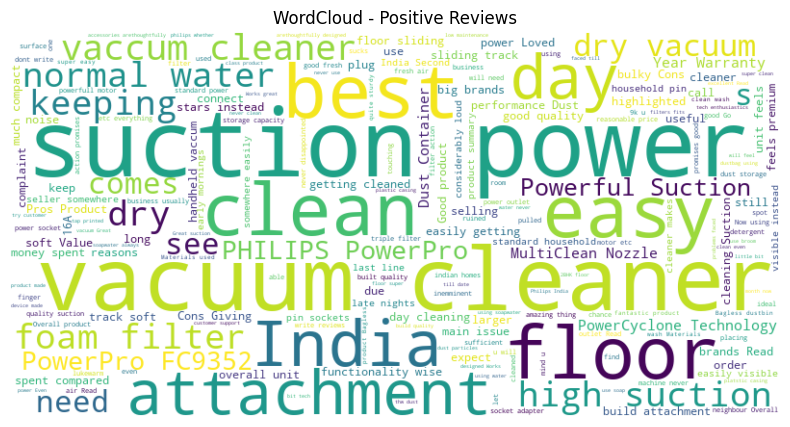

In [156]:
positive_text = " ".join(
    amazon_df[amazon_df['predicted_sentiment'] == 'positive']['body']
)

wc_pos = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Positive Reviews")
plt.show()


In [157]:
amazon_df['processed_review']

0     good product easy use high suction power loved...
1     pro product good quality functionality wise bu...
2     best business usually dont write review produc...
3                                     dont like product
4                                     dont like product
                            ...                        
65    worst purchase ever made quality horrible pack...
66    recently bought philip powerpro fc bagless vac...
67    philip vacuum cleaner fc watt purchased amazon...
68    using year machine never disappointed fantasti...
69    not buy product poorly made unreliable complet...
Name: processed_review, Length: 70, dtype: object

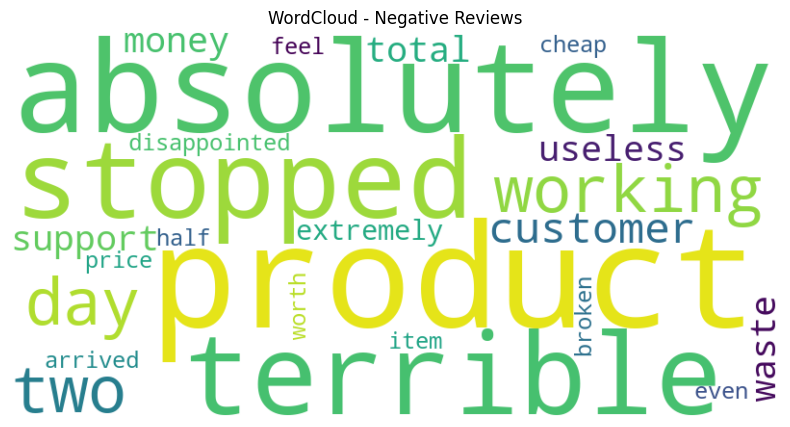

In [158]:
negative_text = " ".join(
    amazon_df[amazon_df['predicted_sentiment'] == 'negative']['processed_review']
)

wc_neg = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Negative Reviews")
plt.show()


### Sentiment Distribution – Bar Chart

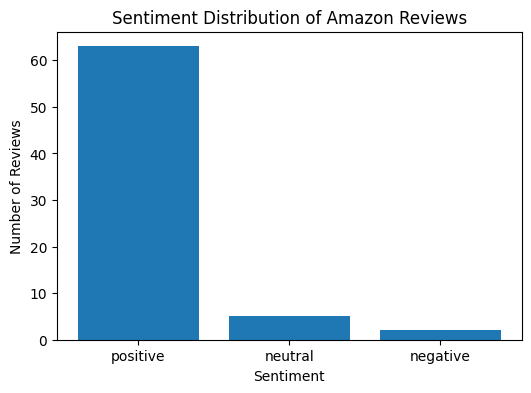

In [159]:
import matplotlib.pyplot as plt

# Count sentiments
sentiment_counts = amazon_df['predicted_sentiment'].value_counts()

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar(sentiment_counts.index, sentiment_counts.values)

plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution of Amazon Reviews")

plt.show()


### Sentiment Distribution – Pie Chart

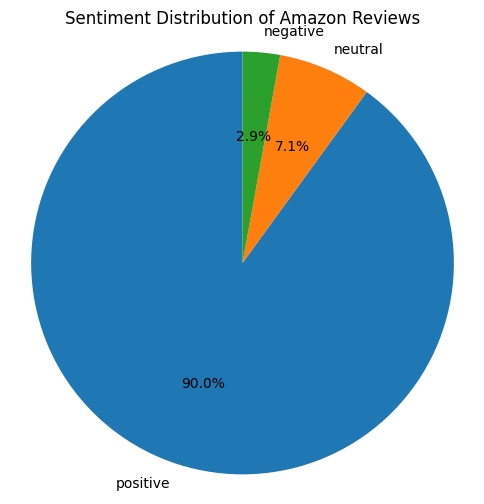

In [160]:
import matplotlib.pyplot as plt

# Count sentiments
sentiment_counts = amazon_df['predicted_sentiment'].value_counts()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Sentiment Distribution of Amazon Reviews")
plt.axis('equal')  # Makes the pie a circle
plt.show()
